In [3]:
# from model_phantom_DB import *
#from plot_functions import * 
import itertools

%matplotlib inline
%config InlineBackend.figure_format = 'png' ## 'svg'

%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score
import pandas as pd

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


## Style of poster for the plots
sns.set_context("poster", font_scale=1.1) ## poster format
sns.set_style("ticks")


For all the matrice data : each row is one trial, each column is one neuron. 
For the same row the trial data may not be collected on the same trial since data might are collected on different days.

cuerate: firing rate during 1st visual stimuli(cue) presentation.

cuerate_stim: firing rate during 1st cue presentation with NB stimulation. 

cdrate: firing rate during the 1st delay after 1st cue presentation. 

cdrate_stim: firing rate during the 1st delay after cue presentation  with NB stimulation.  
 
samplerate: firing rate during 2nd visual stimuli(sample) presentation. 

samplerate_stim: firing rate during sample presentation with NB stimulation. 

sdrate: firing rate during the delay after sample presentation. 

sdrate_stim: firing rate during the delay after sample presentation with NB stimulation. 

g1: location of 1st visual stimuli(cue)
 value -1 means no visual stimuli presented.
 value [1 2 3 4 5] are  relative locaions, such as [0 45 90 135 180], or [ 45 90 135 180 225], etc.
 The real locations depended on neurons' receptive field.
 According to our behavioral paradigm, the cue will only be presented on locaion [1 5]. that is two opposite locations, such as [0 180], [45 225], etc.
 For each neuron, thoes value([1:5]) refer to the same locations.

g2: location of 2nd visual stimuli(sample)
  Sample can show up in all five possible locations([1:5]) or not presented(-1).

g3: task type for each trial, eg. saccade to 1st (value 1), or saccade to 2nd(value 2).


In [4]:
from scipy.io import loadmat 
file = 'C:\\Users\\David\\Desktop\\IDIBAPS\\Classifiy_data_odrdistvar_allNeurons_reverse.matlab'
data = loadmat(file)
data.keys()

dict_keys(['cuerate_stim', 'g3', 'cuerate', 'g1_stim', 'sdrate', 'g2_stim', 'sdrate_stim', 'cdrate_stim', 'cdrate', 'samplerate', 'g1', '__globals__', '__version__', '__header__', 'g2', 'samplerate_stim', 'g3_stim'])

In [5]:
rate_d1_off = data['cdrate']
positions_stim_off= data['g1'] #1, 5, -1 (entiendo que 1 es RF y 5 es opposite, -1 es no estímulo)

rate_d1_on = data['cdrate_stim']
positions_stim_on= data['g1_stim'] #1, 5, -1 (entiendo que 1 es RF y 5 es opposite, -1 es no estímulo)

number_neurons = np.shape(rate_d1_on)[1]

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold

np.warnings.filterwarnings('ignore')

auc_off = np.zeros(number_neurons)
auc_on = np.zeros(number_neurons)

tprs_on = []
tprs_off = []
base_fpr = np.linspace(0, 1, 101)


for Neuron in range(number_neurons):
    ## each column is a neuron
    nx_rates = rate_d1_off[:,Neuron]
    nx_positions = positions_stim_off[:,Neuron]
    ## just get the 1 and 5 (RF and oppoiste)
    nx_y = nx_positions[nx_positions>0]
    nx_x = nx_rates[nx_positions>0]
    ## appropiate shape for the classifier
    y = label_binarize(nx_y, classes=[5,1]) #matrix (1,0,0,...,0)
    y=y.ravel()
    X =np.reshape(nx_x, (len(nx_x),1))
    
    if len(np.unique(y))==1:
        mean_tprs = np.empty(np.shape(base_fpr))*np.nan
    else:
        fpr, tpr, _ = roc_curve(y, nx_x) #HERE: compute ROC with raw spike counts nx_x
        tpr = np.interp(base_fpr, fpr, tpr)
        tpr[0] = 0.0
        mean_tprs = tpr
    tprs_off.append(mean_tprs)

    auc_off[Neuron] = auc(base_fpr, mean_tprs)

    ## each column is a neuron
    nx_rates = rate_d1_on[:,Neuron]
    nx_positions = positions_stim_on[:,Neuron]
    ## just get the 1 and 5 (RF and oppoiste)
    nx_y = nx_positions[nx_positions>0]
    nx_x = nx_rates[nx_positions>0]
    ## appropiate shape for the classifier
    y = label_binarize(nx_y, classes=[5,1]) #matrix (1,0,0,...,0)
    y=y.ravel()
    X =np.reshape(nx_x, (len(nx_x),1))
    
    if len(np.unique(y))==1:
        mean_tprs = np.empty(np.shape(base_fpr))*np.nan
    else:
        fpr, tpr, _ = roc_curve(y, nx_x)
        tpr = np.interp(base_fpr, fpr, tpr)
        tpr[0] = 0.0
        mean_tprs = tpr
    tprs_on.append(mean_tprs)

    auc_on[Neuron] = auc(base_fpr, mean_tprs)





No handles with labels found to put in legend.


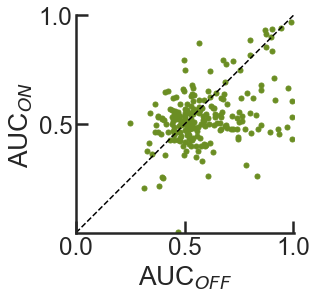

In [7]:
%config InlineBackend.figure_format = 'png' ## 'svg'

plt.plot(auc_off, auc_on, '.', color='olivedrab', markersize=10)
plt.xlabel('AUC$_{OFF}$')
plt.ylabel('AUC$_{ON}$')
plt.axis('scaled');

plt.plot([0, 1], [0, 1], color='k', lw=1.5, linestyle='--')
plt.xlim([0., 1.005])
plt.xticks([0, 0.5, 1])
plt.ylim([0, 1.0])
plt.yticks([0.5, 1])
plt.title('')
plt.gca().spines['right'].set_visible(False)  # aesthetics                                                                              # remove right spines
plt.gca().spines['top'].set_visible(False)                                                                                  # remove top spines
plt.gca().get_xaxis().tick_bottom()                                                                                         
plt.gca().get_yaxis().tick_left()
plt.gca().tick_params(direction='in') #direction
plt.legend(fontsize=14, frameon=False)
plt.show()

In [8]:
import scipy
#np.sum(np.isnan(auc_on))
ind = np.isnan(auc_on)
scipy.stats.ttest_rel(auc_off[~ind], auc_on[~ind])

Ttest_relResult(statistic=5.129432844338237, pvalue=6.39082064663582e-07)

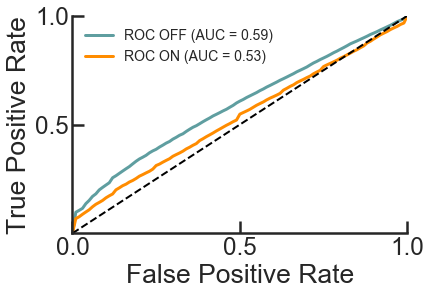

In [12]:
tprs_off = np.array(tprs_off)
tprs_on = np.array(tprs_on)
mean_tprs_off = np.nanmean(tprs_off, axis=0)
mean_tprs_on = np.nanmean(tprs_on, axis=0)
std_off = np.nanstd(tprs_off, axis=0)
std_on = np.nanstd(tprs_on, axis=0)

tprs_upper_off = np.minimum(mean_tprs_off + std_off, 1)
tprs_lower_off = mean_tprs_off - std_off
tprs_upper_on = np.minimum(mean_tprs_on + std_on, 1)
tprs_lower_on = mean_tprs_on - std_on

ax = plt.figure()

plt.plot(base_fpr, mean_tprs_off, 'cadetblue', label='ROC OFF (AUC = {0:0.2f})'''.format(np.mean(auc_off[~ind])))

plt.plot(base_fpr, mean_tprs_on, 'darkorange', label='ROC ON (AUC = {0:0.2f})'''.format(np.mean(auc_on[~ind])))

#plt.fill_between(base_fpr, tprs_lower_off, tprs_upper_off, color='grey', alpha=0.3)
#plt.fill_between(base_fpr, tprs_lower_on, tprs_upper_on, color='grey', alpha=0.3)

plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
plt.xlim([0., 1])
plt.xticks([0, 0.5, 1])
plt.ylim([0, 1.])
plt.yticks([0.5, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('')
plt.legend(loc="lower right", fontsize=10, frameon=False)
plt.gca().spines['right'].set_visible(False)  # aesthetics                                                                              # remove right spines
plt.gca().spines['top'].set_visible(False)                                                                                  # remove top spines
plt.gca().get_xaxis().tick_bottom()                                                                                         
plt.gca().get_yaxis().tick_left()
plt.gca().tick_params(direction='in') #direction
plt.legend(fontsize=14, frameon=False)
plt.show()
ax.savefig('C:\\Users\\David\\Desktop\\ROC_neurons.svg', transparent=True)


In [1]:
0.1*2.4

0.24